# RCM city detection

Looking for urban effects in RCM simulations

In [1]:
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection
import dask
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

In [2]:
var = 'tasmin' # 'rlus'
rcm = 'RCA4'
city = 'Paris'
location = dict(
         NYC = dict(lon=-73.96, lat=40.73),
  Washington = dict(lon=-77.00, lat=38.90),
       Paris = dict(lon=  2.35, lat=48.85)
)
domain = dict(
         NYC = 'NAM-22',
  Washington = 'NAM-22',
       Paris = 'EUR-11'
)
dlon = 20
dlat = 20
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "1"
os.environ["MESA_LOADER_DRIVER_OVERRIDE"]="i965"

sftlf = dict(
  project='CORDEX',
  experiment=['evaluation',],
  rcm_name = 'CRCM5',
  domain = 'NAM-22',
  variable=['sftlf',],
  time_frequency = 'fx',
  facets = 'dataset_id'
)

vardic = dict(
  project='CORDEX',
  experiment=['evaluation',],
  rcm_name = rcm,
  domain = domain[city],
  variable=[var,],
  time_frequency = 'day',
  facets = 'dataset_id'
)

nodeURL = 'http://esgf-data.dkrz.de/esg-search'
#nodeURL = 'https://esgf-index1.ceda.ac.uk/esg-search'
conn = SearchConnection(nodeURL, distrib=True)

def ESGF_login():
  lm = LogonManager()
  lm.logoff()
  with open("openid.json") as fp:
    lm.logon_with_openid(**json.load(fp))
  if lm.is_logged_on():
    print("You are logged in!")
  else:
    print("/!\ There was some problem logging in")

def index_argmax(ds):    
  return(
    ds[var]
      .isel(time = ds[var].mean(dim=['rlon','rlat']).argmax(dim='time').values)
  )

def index_quantile(ds):
  return(
    (ds - ds.mean(dim=['rlon','rlat']))[var]
  #  (ds[var] - ds[var].isel(rlon=5,rlat=4).drop(['rlon', 'rlat','lon','lat',]))
      .groupby('time.season')
      .quantile(0.95, 'time')
      .sel(season='JJA')
  )

compute_index = index_argmax

We need to log in to ESGF to retrieve data

In [3]:
ESGF_login()

You are logged in!


Persist the data on disk

In [4]:
%%time

ctx = conn.new_context(**vardic)
results = ctx.search(batch_size=200)
dids = [result.dataset_id for result in results]
ires = 0
files = results[ires].file_context().search()
opendap_urls = [file.opendap_url for file in files]

opendap_urls

['http://esg-dn1.nsc.liu.se/thredds/dodsC/esg_dataroot1/cordexdata/cordex/output/EUR-11/SMHI/ECMWF-ERAINT/evaluation/r1i1p1/SMHI-RCA4/v1/day/tasmin/v20131026/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_SMHI-RCA4_v1_day_19800101-19801231.nc',
 'http://esg-dn1.nsc.liu.se/thredds/dodsC/esg_dataroot1/cordexdata/cordex/output/EUR-11/SMHI/ECMWF-ERAINT/evaluation/r1i1p1/SMHI-RCA4/v1/day/tasmin/v20131026/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_SMHI-RCA4_v1_day_19810101-19851231.nc',
 'http://esg-dn1.nsc.liu.se/thredds/dodsC/esg_dataroot1/cordexdata/cordex/output/EUR-11/SMHI/ECMWF-ERAINT/evaluation/r1i1p1/SMHI-RCA4/v1/day/tasmin/v20131026/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_SMHI-RCA4_v1_day_19860101-19901231.nc',
 'http://esg-dn1.nsc.liu.se/thredds/dodsC/esg_dataroot1/cordexdata/cordex/output/EUR-11/SMHI/ECMWF-ERAINT/evaluation/r1i1p1/SMHI-RCA4/v1/day/tasmin/v20131026/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_SMHI-RCA4_v1_day_19910101-19951231.nc',
 'http://esg-dn1.nsc.liu.se/

In [9]:
%%time

ds = xr.open_mfdataset(opendap_urls,
  parallel=True, chunks={'time':100},
  combine='nested', concat_dim='time',
  drop_variables = ['time_bnds']
)
ds.isel(time=0).to_netcdf('test.nc')

CPU times: user 282 ms, sys: 55.8 ms, total: 338 ms
Wall time: 2.46 s


In [ ]:
%%time

dist = (ds['lon']-location[city]['lon'])**2 + (ds['lat']-location[city]['lat'])**2
[ilat], [ilon] = np.where(dist == np.min(dist))
ds_city = ds.isel(rlat=slice(ilat-dlat,ilat+dlat), rlon=slice(ilon-dlon,ilon+dlon))
#ds_city = ds.isel(y=slice(ilat-dlat,ilat+dlat), x=slice(ilon-dlon,ilon+dlon))
fname = os.path.basename(opendap_urls[0])[:-21] + f'_{city}.nc'
ds_city.to_netcdf(fname, encoding = { var: {"zlib": True, "complevel": 9} })

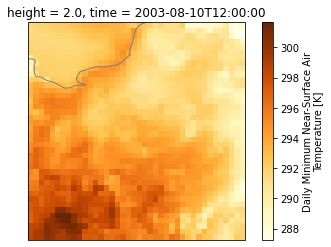

In [6]:
ds_city = xr.open_dataset(fname)
index = compute_index(ds_city)
# Projected plot
import cartopy.crs as ccrs
lonlat = ccrs.PlateCarree()
projvar = 'rotated_pole'
proj = ccrs.RotatedPole(
  pole_longitude=ds_city[projvar].grid_north_pole_longitude,
  pole_latitude=ds_city[projvar].grid_north_pole_latitude
)
f = plt.figure()
ax = plt.axes(projection=proj)
index.plot.pcolormesh(
  ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.YlOrBr#, vmax=10
  #ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.RdBu, vmax=5
)
ax.coastlines(resolution='50m', linewidth=1, color='gray')
plt.show()
plt.close('all')